In [1]:
# Импортируем библиотеки

import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Определяем функцию для расчета сглаженного ctr

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [3]:
# Вытаскиваем данные из clickhouse для групп 1 и 2 в период с 2023-01-31 по 2023-02-06

connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230220',
              'user':'student', 
              'password':'dpo_python_2020'
              }

query = '''
select exp_group,
       user_id,
       sum(action='like') likes,
       sum(action='view') views,
       likes/views ctr
from {db}.feed_actions 
where toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06'
      and exp_group in (1, 2)
group by exp_group,
       user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [4]:
# Производим расчет global ctr для наших групп

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

# Производим расчет сглаженного ctr 

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

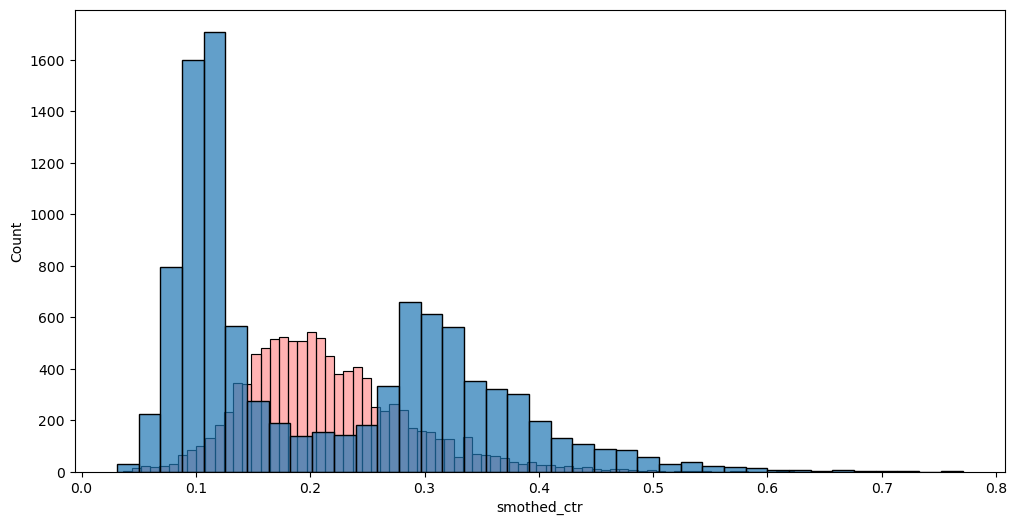

In [5]:
# Рисуем гистограмму распределения сглаженных поюзерных ctr
plt.figure(figsize=(12, 6))

sns.histplot(data = group1, 
              x='smothed_ctr',
              color='red',
              alpha=0.3,
              kde=False)

sns.histplot(data = group2, 
              x='smothed_ctr',
              alpha=0.7,
              kde=False)

In [6]:
# Проводим t-тест
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.022376981555855876)

In [7]:
# Проводим тест Манна-Уитни
stats.mannwhitneyu(group1.smothed_ctr,
                   group2.smothed_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

In [8]:
group1.smothed_ctr.mean()

0.21402549608884278

In [9]:
group2.smothed_ctr.mean()

0.21073955503259295